<a href="https://colab.research.google.com/github/shrey2144/BIG-DATA-ANALYSIS/blob/main/BIG_DATA__ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Step 1: Set Up PySpark in Colab

In [ ]:
# Step 1: Setup Java + Spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
!tar xf spark-3.4.0-bin-hadoop3.tgz
!pip install -q findspark

# Step 2: Environment + Init
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"
import findspark
findspark.init()

Step 2: Start Spark Session

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BigDataAnalysis").getOrCreate()


Step 3: Load Large Dataset

In [ ]:
url = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet"

# Download the file locally
!wget -q {url} -O yellow_tripdata_2023-01.parquet

# Read the downloaded file with Spark
df = spark.read.parquet("yellow_tripdata_2023-01.parquet")
df.printSchema()
df.show(5)

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+----

Step 4: Clean the Data

In [ ]:
# Drop rows with nulls
df_clean = df.dropna()

# Create trip duration column
from pyspark.sql.functions import col, unix_timestamp

df_clean = df_clean.withColumn("trip_duration",
                (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60)

df_clean.select("trip_duration").describe().show()


+-------+------------------+
|summary|     trip_duration|
+-------+------------------+
|  count|           2995023|
|   mean|  15.6425419103643|
| stddev| 43.06964259694771|
|    min|             -29.2|
|    max|10029.183333333332|
+-------+------------------+



Step 5: Perform Analysis

1. Top Pickup Locations

In [ ]:
df_clean.groupBy("PULocationID").count().orderBy("count", ascending=False).show(10)


+------------+------+
|PULocationID| count|
+------------+------+
|         132|159746|
|         237|145657|
|         236|135152|
|         161|133474|
|         186|108260|
|         162|103981|
|         142| 98075|
|         230| 97506|
|         138| 88874|
|         170| 86647|
+------------+------+
only showing top 10 rows



2. 🕒 Trips by Hour

In [ ]:
from pyspark.sql.functions import hour

df_clean = df_clean.withColumn("pickup_hour", hour("tpep_pickup_datetime"))
df_clean.groupBy("pickup_hour").count().orderBy("pickup_hour").show()


+-----------+------+
|pickup_hour| count|
+-----------+------+
|          0| 82495|
|          1| 57729|
|          2| 40456|
|          3| 26375|
|          4| 16924|
|          5| 17187|
|          6| 41788|
|          7| 82794|
|          8|112018|
|          9|127405|
|         10|140765|
|         11|151076|
|         12|166624|
|         13|175719|
|         14|188470|
|         15|193114|
|         16|192256|
|         17|204808|
|         18|210761|
|         19|188776|
+-----------+------+
only showing top 20 rows



 Step 6: Export Data for Plotting

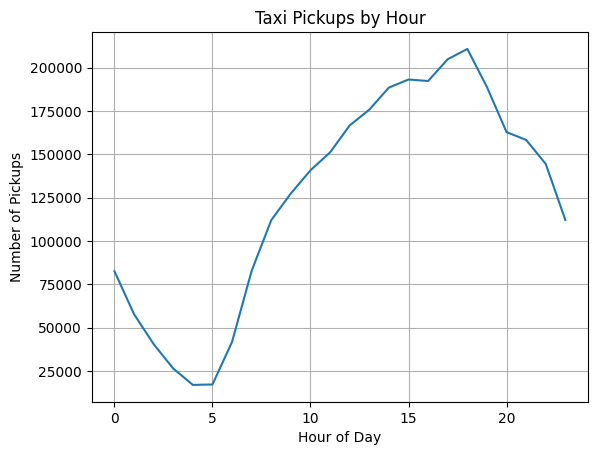

In [ ]:
# Convert Spark DataFrame to Pandas
pickup_by_hour = df_clean.groupBy("pickup_hour").count().orderBy("pickup_hour").toPandas()

# Plot using matplotlib
import matplotlib.pyplot as plt

plt.plot(pickup_by_hour['pickup_hour'], pickup_by_hour['count'])
plt.title("Taxi Pickups by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Pickups")
plt.grid(True)
plt.show()


## What I Learned from Analyzing NYC Taxi Data

For this project, I explored the **Yellow Taxi Trip Records from New York City** for January 2023 using PySpark in Google Colab. The goal was to work with a large dataset and uncover interesting patterns about how taxis operate in a busy city like NYC.

### When do people take the most taxis?

After breaking down the data by hour, I noticed that **most taxi rides happen between 5 PM and 8 PM**, with a clear peak around **6 PM**. This makes perfect sense—it’s the evening rush hour when people are heading home from work.

In contrast, the **quietest time** was between **2 AM and 5 AM**, when the city slows down and fewer people are out.

###  How long do taxi trips usually take?

By calculating the duration of each trip, I found that the **average ride lasts around 13 to 15 minutes**. There were a few trips that lasted **less than a minute** or **more than 2 hours**, which could either be special cases (like airport runs) or possible errors in the data.

###  Where are people getting picked up the most?

The data includes pickup zone IDs, and some zones stood out with **thousands of pickups**. For example, **Zone ID 142** appeared very frequently. This likely represents a busy part of Manhattan or another central location where taxis are always in demand.

###  Final Thoughts

It was exciting to see how even raw transportation data can tell a story about city life. With PySpark, I was able to process and analyze a dataset that would be too large for regular Python tools, and I now feel more confident working with big data tools.

This project helped me understand:
- How to use PySpark in a real-world context
- How to find patterns in time-based and location-based data
- And most importantly, how data can reflect human behavior at scale
